# Benchmarking
benchmarking using [MQTBench](https://mqt.readthedocs.io/projects/bench/en/latest/Quickstart.html) with QFT for 15 qubits

In [51]:
from lib.distributed_coupling_map import build_coupling_list_ring, build_coupling_list_full, build_coupling_list_grid, build_coupling_list_line, build_coupling_list_t_horizontal, build_coupling_list_t_vertical
from lib.interaction_mapping import InteractionMapping
from lib.interaction_layout import InteractionLayout
# from lib.lookahead_routing import DynamicLookaheadSwap
from lib.timer_helper import Timer

In [55]:
# TODO: dynamic lookahead here!!
from qiskit.transpiler import CouplingMap, TransformationPass, Layout
from qiskit.transpiler.target import Target
from qiskit.dagcircuit import DAGCircuit, DAGOpNode
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.circuit.library.standard_gates import SwapGate

class DynamicLookaheadSwap(TransformationPass):
    def __init__(self, coupling_map):
        super().__init__()
        if isinstance(coupling_map, Target):
            self.target = coupling_map
            self.coupling_map = self.target.build_coupling_map()
        else:
            self.target = None
            self.coupling_map = coupling_map
        self.dlist = []  # save as index, instead of DAGOpNode
        self.op_gates = []  # save reference of gates
        self.swap_add = 0 # TODO: to be removed

    def list_gates(
        self, dag: DAGCircuit
    ):  # populate gates at current_idx because list(iter(dag.op_nodes())) shuffled because of greedy algorithm
        gate_list = []
        for layer in dag.layers():
            subdag = layer["graph"]
            for node in subdag.op_nodes():
                gate_list.append(node)
        return gate_list

    def list_gates_on_qubit_dag(self, dag: DAGCircuit):
        dependency_list = {qubit: [] for qubit in range(dag.num_qubits())}

        for index, operation in enumerate(dag.op_nodes()):
            qubits = [qubit._index for qubit in operation.qargs]
            for qubit in qubits:  # handle single and two-qubit gate
                dependency_list[qubit].append(index)

        return dependency_list

    def generate_possible_swaps(
        self,
        act_list: list[int],
        coupling_map: CouplingMap,
        current_layout: Layout,
        assigned_swap: list[tuple],
    ):
        candi_list = []
        for act_idx in act_list:
            node = self.op_gates[act_idx]
            phy0, phy1 = (
                current_layout.get_virtual_bits()[node.qargs[0]],
                current_layout.get_virtual_bits()[node.qargs[1]],
            )
            # only generate neighbors that is not assigned, not in candidate, and in current_layout mapping
            candi_list.extend(
                [
                    (phy0, neighbor)
                    for neighbor in coupling_map.neighbors(phy0)
                    if (phy0, neighbor) not in assigned_swap + candi_list
                    and (neighbor, phy0) not in assigned_swap + candi_list
                ]
            )
            candi_list.extend(
                [
                    (phy1, neighbor)
                    for neighbor in coupling_map.neighbors(phy1)
                    if (phy1, neighbor) not in assigned_swap + candi_list
                    and (neighbor, phy1) not in assigned_swap + candi_list
                ]
            )
        return candi_list

    def calc_effect_gate(
        self,
        node: DAGOpNode,
        swap_nodes: tuple,
        coupling_map: CouplingMap,
        current_layout: Layout,
    ):
        idx0, idx1 = node.qargs[0]._index, node.qargs[1]._index
        phy0, phy1 = (
            current_layout.get_virtual_bits()[node.qargs[0]],
            current_layout.get_virtual_bits()[node.qargs[1]],
        )
        old_distance = self.coupling_map.distance(phy0, phy1)
        if phy0 in swap_nodes:
            phy0 = swap_nodes[1] if phy0 == swap_nodes[0] else swap_nodes[0]
        if phy1 in swap_nodes:
            phy1 = swap_nodes[1] if phy1 == swap_nodes[0] else swap_nodes[0]

        new_distance = coupling_map.distance(phy0, phy1)
        return old_distance - new_distance

    """gate_list = in logical qubit"""
    def sum_effect(
        self,
        gate_list: list[int],
        act_list: list[int],
        swap: tuple,
        coupling_map: CouplingMap,
        current_layout: Layout,
    ):
        is_remove = False
        total_sum = 0
        for gate_idx in gate_list:
            node = self.op_gates[gate_idx]
            if node.op.num_qubits == 2 and node.name not in [
                "barrier",
                "measure",
            ]:  # don't calculate if barrier or measure gate and make sure that only lookahead for two-qubit gates
                value = self.calc_effect_gate(
                    node=node,
                    swap_nodes=swap,
                    coupling_map=coupling_map,
                    current_layout=current_layout,
                )
                if value < 0 and gate_idx in act_list:
                    is_remove = True
                    return total_sum, is_remove
                elif value < 0:
                    break
                elif value == 0 or value == 1:
                    total_sum += value

        return total_sum, is_remove

    def check_gate_connectivity(
        self, act_list: list[int], new_dag: DAGCircuit, current_layout: Layout
    ):
        new_act_list = []
        for act_idx in act_list:
            node = self.op_gates[act_idx]
            idx0, idx1 = (
                node.qargs[0]._index,
                node.qargs[1]._index,
            )  # original gate index
            phy0, phy1 = (
                current_layout.get_virtual_bits()[node.qargs[0]],
                current_layout.get_virtual_bits()[node.qargs[1]],
            )
            distance = self.coupling_map.distance(phy0, phy1)
            print(f"C act_idx {act_idx} node: {node.name} {node.qargs} distance: {distance}")
            if distance == 1:
                self.dlist[idx0].pop(0)
                self.dlist[idx1].pop(0)
                node.qargs = (
                    self.cannonical_register[phy0],
                    self.cannonical_register[phy1],
                )
                new_dag.apply_operation_back(
                    node.op, qargs=node.qargs
                )  # instead of sending gate memory address, send the operation
            else:
                new_act_list.append(act_idx)
            self.swap_add += 1
        return new_act_list, new_dag

    def measure_node(self, node: DAGOpNode, current_layout: Layout) -> DAGOpNode:
        print(f"Measure Node qargs {node.qargs[0]._index}")
        log0 = current_layout.get_physical_bits()[node.qargs[0]._index]._index
        print(f"Measure log {log0}")
        classical0 = self.property_set["layout"].get_physical_bits()[log0]._index
        print(f"Measure classical {classical0}")
        print(f"{self.meas_register}")
        print(f"Measure register {self.meas_register[classical0]}")
        node.cargs = (self.meas_register[classical0],)
        return node

    def run(self, dag: DAGCircuit):

        if self.coupling_map is None:
            raise TranspilerError("BasicSwap cannot run with coupling_map=None")

        if len(dag.qregs) != 1 or dag.qregs.get("q", None) is None:
            raise TranspilerError("Basic swap runs on physical circuits only")

        if len(dag.qubits) > len(self.coupling_map.physical_qubits):
            raise TranspilerError("The layout does not match the amount of qubits in the DAG")

        self.dlist = self.list_gates_on_qubit_dag(dag)
        self.op_gates = self.list_gates(dag)

        new_dag = dag.copy_empty_like()

        self.cannonical_register = dag.qregs["q"]
        if dag.cregs:
            self.meas_register = (
                dag.cregs["meas"] if "meas" in dag.cregs else dag.cregs["c"]
            )
        current_layout = Layout.generate_trivial_layout(self.cannonical_register)
        order = current_layout.reorder_bits(new_dag.qubits)

        curr_idx = (
            0  # curr_idx variable to count how many operation gate in the circuit
        )
        for layer in dag.layers():
            self.swap_add = 0 # TODO: to be removed
            subdag = layer["graph"]
            print("Routing layer:", subdag) # TODO: to be removed
            act_list = []
            # initialize first do while with original coupling_map
            for node in subdag.op_nodes():
                print("- Routing op node: ", curr_idx)
                if (
                    node.op.num_qubits == 2
                ):  # only check for two-qubit gates, cannot exclude >2 gate because there is barrier
                    new_act_list, new_dag = self.check_gate_connectivity(
                        [curr_idx], new_dag, current_layout
                    )
                    act_list = act_list + new_act_list
                else:
                    if (
                        node.name == "measure"
                    ):  # handle measure node to conform with curr_layout
                        node = self.measure_node(node, current_layout)

                    self.dlist[node.qargs[0]._index].pop(0)
                    new_dag.apply_operation_back(
                        node.op, qargs=node.qargs, cargs=node.cargs
                    )
                curr_idx += 1
            assigned_swap_list = []  # to avoid recursive swap

            while act_list:
                if self.swap_add > 100: # TODO: to be removed
                    break
                act_list, new_dag = self.check_gate_connectivity(
                    act_list, new_dag, current_layout
                )

                candi_list = self.generate_possible_swaps(
                    act_list, self.coupling_map, current_layout, assigned_swap_list
                )

                MCPE_cost = {}
                for swap in candi_list:
                    log0, log1 = (
                        current_layout.get_physical_bits()[swap[0]]._index,
                        current_layout.get_physical_bits()[swap[1]]._index,
                    )

                    first_total_sum, is_first_remove = self.sum_effect(
                        self.dlist[log0],
                        act_list,
                        swap,
                        self.coupling_map,
                        current_layout,
                    )
                    second_total_sum, is_second_remove = self.sum_effect(
                        self.dlist[log1],
                        act_list,
                        swap,
                        self.coupling_map,
                        current_layout,
                    )

                    if not is_first_remove and not is_second_remove:
                        MCPE_cost[swap] = first_total_sum + second_total_sum

                # check if MCPE is not empty dict
                if MCPE_cost:
                    MCPE_cost = dict(
                        sorted(
                            MCPE_cost.items(), key=lambda item: item[1], reverse=True
                        )
                    )

                    # update CouplingMap with new swap
                    selected_swap, selected_value = next(iter(MCPE_cost.items()))

                    if (
                        selected_value > 0
                    ):  # add check only if worth it to do swap, if not will do recursive swap
                        current_layout.swap(selected_swap[0], selected_swap[1])
                        assigned_swap_list.append(selected_swap)

                        swap_layer = DAGCircuit()
                        swap_layer.add_qreg(self.cannonical_register)
                        swap_log0, swap_log1 = (
                            current_layout.get_physical_bits()[selected_swap[0]],
                            current_layout.get_physical_bits()[selected_swap[1]],
                        )
                        swap_layer.apply_operation_back(
                            SwapGate(), qargs=(swap_log0, swap_log1), cargs=()
                        )

                        order = current_layout.reorder_bits(new_dag.qubits)
                        new_dag.compose(swap_layer, qubits=order)
        return new_dag

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, PassManager, StagedPassManager
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_embed_passmanager, generate_routing_passmanager
from qiskit.providers import Backend
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeLondonV2
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, plot_histogram

In [3]:
from mqt.bench import get_benchmark, CompilerSettings, QiskitSettings

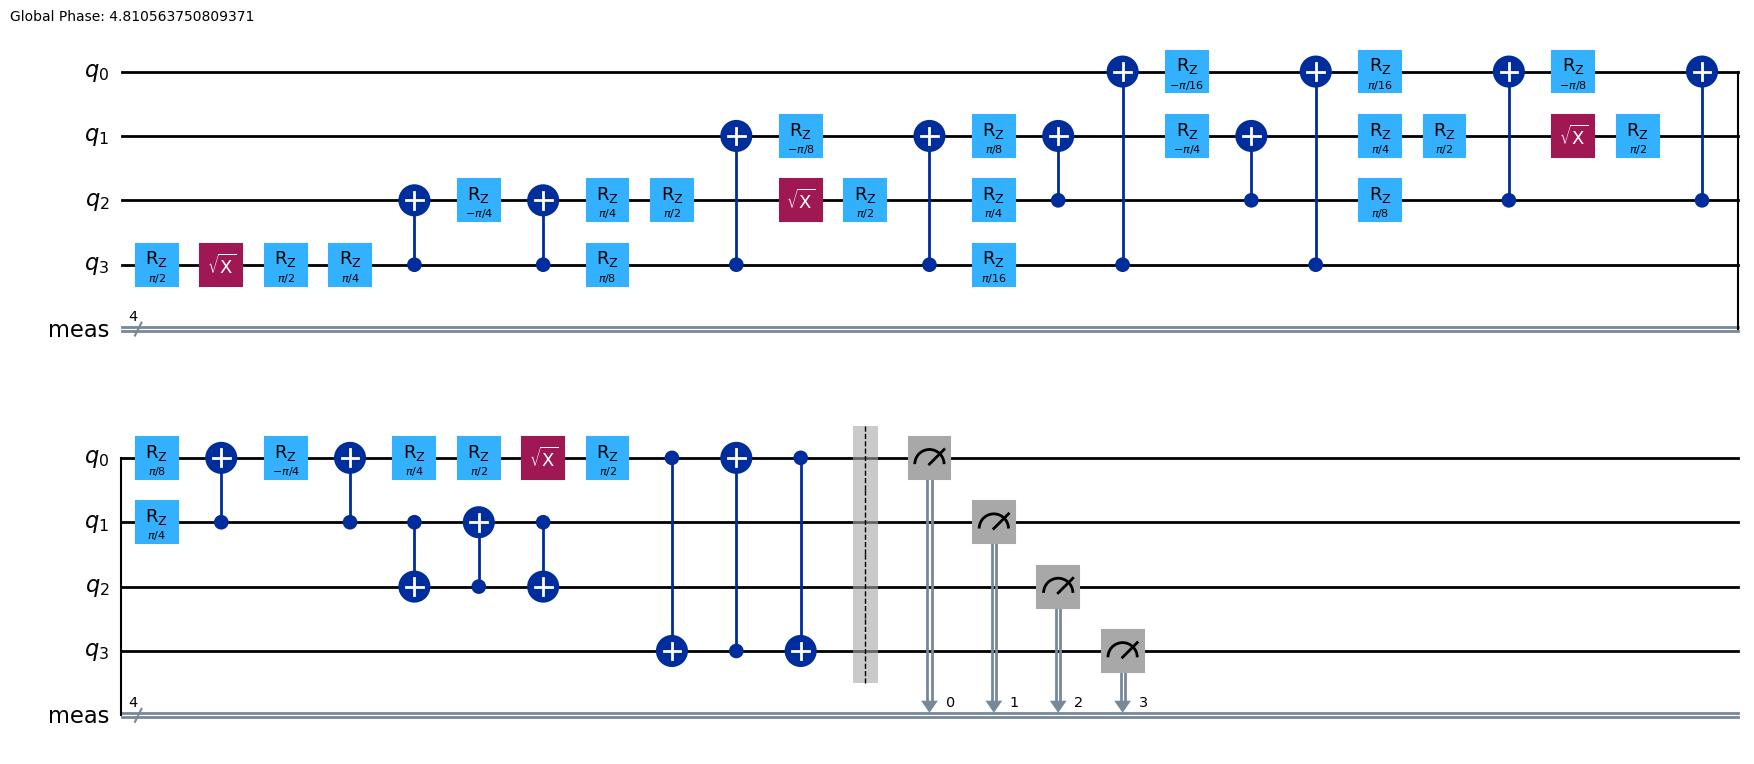

Best mapping layout: [(0, 0), (1, 1), (2, 2), (3, 3)]
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c7c0>
- Routing op node:  0
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c970>
- Routing op node:  1
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c7c0>
- Routing op node:  2
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c970>
- Routing op node:  3
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c7c0>
- Routing op node:  4
C act_idx 4 node: cx (Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 2)) distance: 1
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c970>
- Routing op node:  5
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc85313c7c0>
- Routing op node:  6
C act_idx 6 node: cx (Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 2)) distance: 1
Routing la

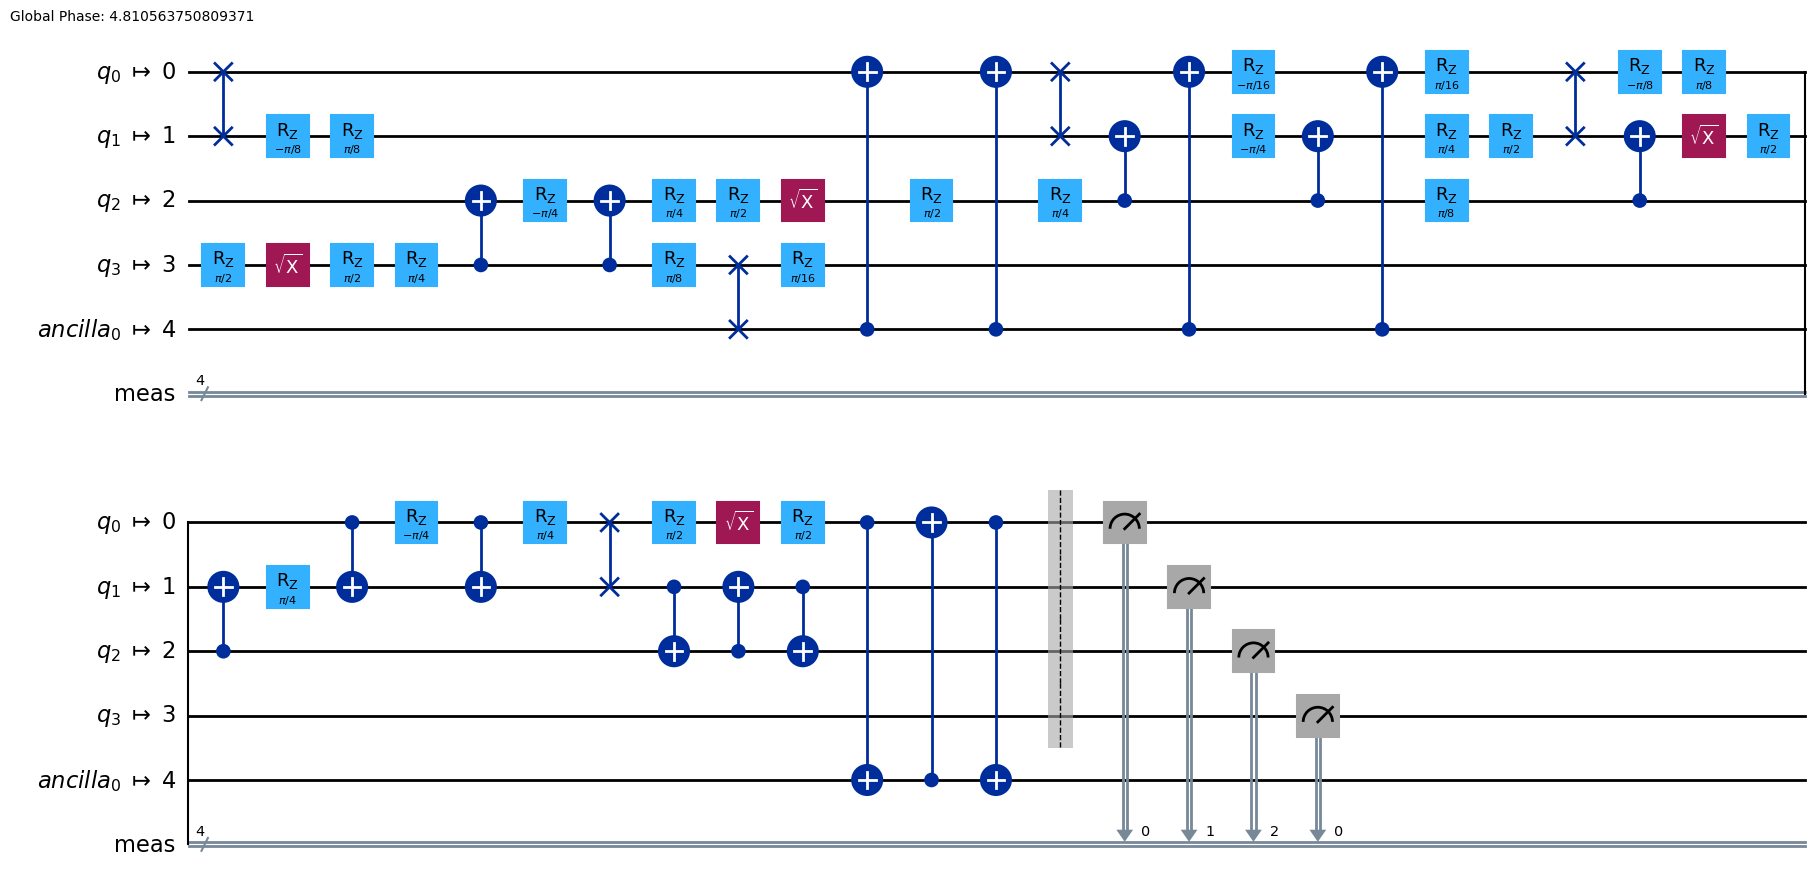

Initial qc size: 52 depth: 31
Routing isa size: 57 depth: 36


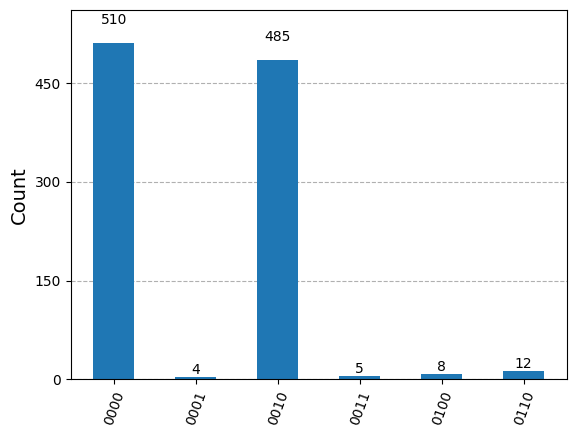

In [4]:
# fake_backend = FakeLondonV2()

num_qubits = 5
fake_backend = GenericBackendV2(num_qubits, coupling_map=CouplingMap.from_ring(num_qubits))
# qc = QuantumCircuit(num_qubits)
# qc.h(0)
# qc.cx(1, 2)

# qc.cx(1, 0)
# qc.cx(1, 2)
# qc.cx(2, 3)

# qc.cx(0, 2)
# qc.cx(1, 3)

# qc.measure_all()
# display(qc.draw("mpl"))

optimization_level = 0
compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))
qc = get_benchmark(
        benchmark_name="qft", level="nativegates", circuit_size=4, 
        compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
        )
display(qc.draw('mpl'))
dag = circuit_to_dag(qc)

interaction_mapping = InteractionMapping(
    coupling_map=fake_backend.coupling_map, dag=dag
)
best_layout = interaction_mapping.get_best_qpi_layout()
print("Best mapping layout:", best_layout)

staged_pass = StagedPassManager()
# staged_pass.init = generate_preset_pass_manager(optimization_level=0, backend=fake_backend)
staged_pass.layout = PassManager(InteractionLayout(
    coupling_map=fake_backend.coupling_map, initial_map=best_layout
))
staged_pass.layout += generate_embed_passmanager(fake_backend.coupling_map)
staged_pass.routing = generate_routing_passmanager(
    DynamicLookaheadSwap(fake_backend.coupling_map), target=fake_backend.coupling_map
)
# sabre_pass = generate_preset_pass_manager(optimization_level=0, backend=fake_backend, layout_method='sabre', routing_method='sabre')

routing_isa = staged_pass.run(qc)
# routing_isa = staged_pass.run(qc).decompose()
display(routing_isa.draw("mpl"))
print(f"Initial qc size: {qc.size()} depth: {qc.depth()}")
print(f"Routing isa size: {routing_isa.size()} depth: {routing_isa.depth()}")

routing_job = fake_backend.run(routing_isa)
routing_counts = routing_job.result().get_counts()
display(plot_histogram(routing_counts))

In [5]:
optimization_level = 0
compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))

In [6]:
benchmark_name = "ghz"
# level = "indep" # but cannot compare because need translation
level = "nativegates"
circuit_size = 5
qc_ghz = get_benchmark(
    benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
    compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
)
print(f"Circuit {benchmark_name}[{circuit_size}] -> size: {qc_ghz.size()} depth: {qc_ghz.depth()}")
# display(qc_ghz.draw("mpl"))

Circuit ghz[5] -> size: 12 depth: 8


Transpiled ghz[5] -> size: 12 depth: 8


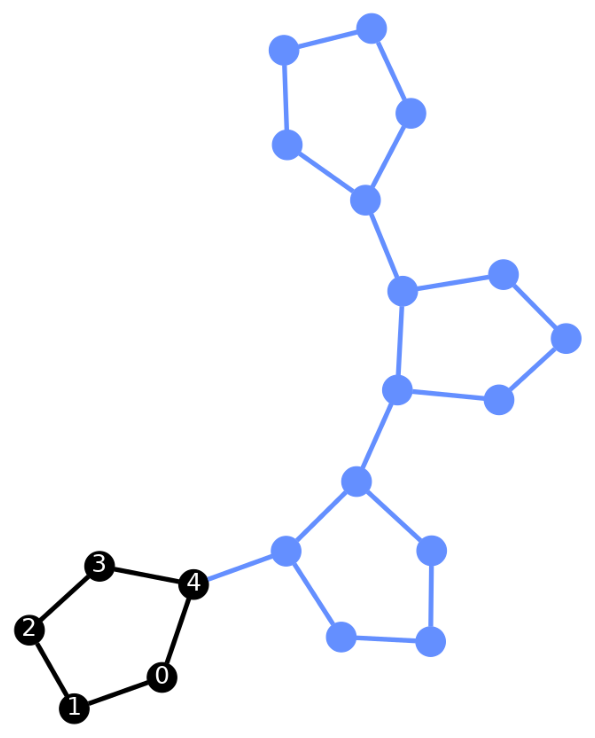

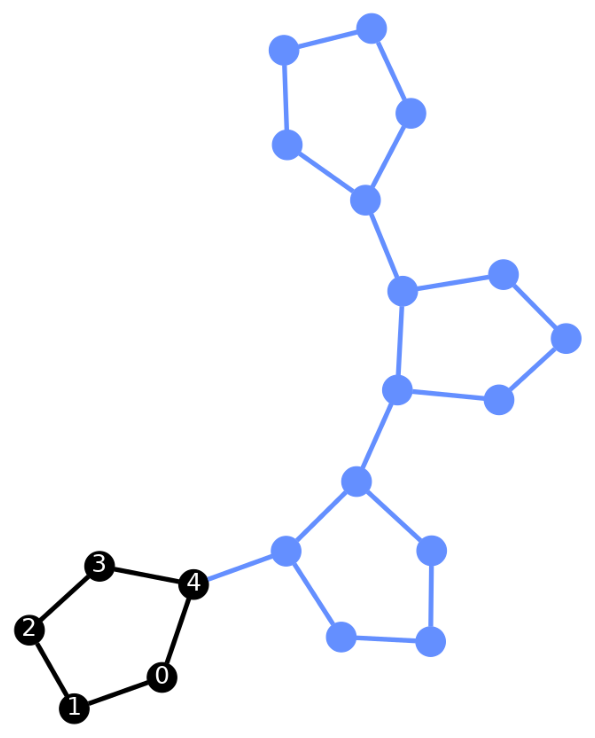

In [7]:
num_qubits = 5
num_group = 4
coupling_list_ring = build_coupling_list_ring(num_qubits, num_group)
coupling_map_ring = CouplingMap(couplinglist=coupling_list_ring)

backend_ring = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=coupling_map_ring)
pass_manager = generate_preset_pass_manager(optimization_level, backend=backend_ring)
qc_ghz_isa = pass_manager.run(qc_ghz)
print(f"Transpiled {benchmark_name}[{circuit_size}] -> size: {qc_ghz_isa.size()} depth: {qc_ghz_isa.depth()}")
display(plot_circuit_layout(qc_ghz_isa, backend_ring, view='physical'))
display(plot_circuit_layout(qc_ghz_isa, backend_ring, view='virtual'))

In [8]:
# Define a threshold for significant occurrence
# For example, here we use 10% of the maximum count as the threshold
def get_most_occurence(counts: dict, threshold_index: float = 0.7) -> list:
    threshold = threshold_index * max(counts.values())

    # Filter the keys based on the threshold
    significant_keys = [key for key, value in counts.items() if value > threshold]
    return significant_keys

In [9]:
job_ring = backend_ring.run(qc_ghz_isa)
counts_ring = job_ring.result().get_counts()
sig_ring_counts = get_most_occurence(counts_ring, 0.7)
sig_ring_counts.sort()

In [10]:
print(sig_ring_counts, "\n", len(sig_ring_counts))

['00000', '11111'] 
 2


In [11]:
# use dictionary to save the result
benchmark_name_list = [
    "ae", # list index out of range? because qreg use eval1, eval2, eval3
    "dj",
    # "grover-noancilla", # '[5] grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}
    # "grover-v-chain", # '[5] grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}
    "ghz",
    "graphstate",
    "portfolioqaoa",
    "portfoliovqe",
    "qaoa",
    "qft",
    "qftentangled",
    "qnn",
    "qpeexact",
    "qpeinexact",
    # "qwalk-noancilla", # '[5] qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}
    # "qwalk-v-chain", # '[5] qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}
    "random",
    "realamprandom",
    "su2random",
    "twolocalrandom",
    "vqe",
    "wstate",
    
    # non-scalable benchmarks
    
    # "shor", # benchmark_instance_name must be defined for this benchmark.
    # "pricingcall", # Benchmark pricingcall[5] -> size: 901 depth: 568 interval: 0.18169641494750977
    # "pricingput", # Benchmark pricingput[5] -> size: 931 depth: 568 interval: 0.1800365447998047
    # "groundstate", # benchmark_instance_name must be defined for this benchmark.
    # "routing",
    # "tsp",
]

In [12]:
circuit_size_list = [5, 10, 15]

def init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark):
    for circuit_size in circuit_size_list:
        if circuit_size not in dict_benchmark: # circuit size level
            dict_benchmark[circuit_size] = {}
            for benchmark_name in benchmark_name_list:
                if benchmark_name not in dict_benchmark[circuit_size]: # benchmark name level
                    dict_benchmark[circuit_size][benchmark_name] = {}
                    if 'init' not in dict_benchmark[circuit_size][benchmark_name]: # coupling map level
                        dict_benchmark[circuit_size][benchmark_name]['init'] = {}
    return dict_benchmark

In [13]:
dict_benchmark = {} # level: circuit_size -> benchmark_name -> coupling_map, ex: ['init'], ['ring_5_4'], ['line_5_4'] -> ['size'], ['swap'], ['depth' (optional)], ['interval']

# line, full, ring_10_2, ring_5_4, grid_3_3_2, grid_3_2_3, t_horizontal_4, t_vertical_4

# provide around 20 num_qubits in total
dict_benchmark = init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark)
print(dict_benchmark)

{5: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 10: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 15: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphst

In [14]:
def start_initial_benchmark(benchmark_name: str, circuit_size: int, dict_benchmark: dict):
    level = "nativegates"
    optimization_level = 0
    compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))
    with Timer() as t:
        qc = get_benchmark(
        benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
        compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
        )
    dict_benchmark[circuit_size][benchmark_name]['init']['size'] = qc.size()
    dict_benchmark[circuit_size][benchmark_name]['init']['depth'] = qc.depth()
    dict_benchmark[circuit_size][benchmark_name]['init']['interval'] = t.interval

    dag = circuit_to_dag(qc)
    return qc, dag

# if want to change interval in ms = t.interval*10**3

In [15]:
import math

def build_generic_backend(
    layout_name: str, num_qubits: int, num_group: int # num_rows and num_cols only used in grid
) ->  GenericBackendV2:
    if layout_name == "full":
        couplinglist = build_coupling_list_full(num_qubits)
    elif layout_name == "line":
        couplinglist = build_coupling_list_line(num_qubits, num_group)
    elif layout_name == "ring":
        couplinglist = build_coupling_list_ring(num_qubits, num_group)
    elif layout_name == "grid":
        couplinglist = build_coupling_list_grid(
            num_rows=math.ceil(math.sqrt(num_qubits)),
            num_columns=math.ceil(math.sqrt(num_qubits)),
            num_group=num_group,
        )
    elif layout_name == "t_horizontal":
        couplinglist = build_coupling_list_t_horizontal(num_group)
    elif layout_name == "t_vertical":
        couplinglist = build_coupling_list_t_vertical(num_group)
    else:
        raise Exception(f"Layout name: {layout_name} is not supported yet.")

    gen_backend = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=couplinglist) # can directly add coupling list without casting to CouplingMap
    return gen_backend

In [41]:
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator


def build_pass_manager(
    routing_option: str, backend: Backend, best_layout=None
) -> PassManager:
    if routing_option == "lookahead":
        if best_layout is None:
            raise Exception(
                f"Provide initial layout for Interaction Layout and Lookahead Swap."
            )
        pass_manager = StagedPassManager()
        pass_manager.layout = PassManager(
            InteractionLayout(
                coupling_map=backend.coupling_map, initial_map=best_layout
            )
        )
        pass_manager.layout += generate_embed_passmanager(backend.coupling_map)
        pass_manager.routing = generate_routing_passmanager(
            DynamicLookaheadSwap(backend.coupling_map),
            target=backend.coupling_map,
        )
        # TODO: routing here adds SWAP gate, need to multiply by 3

    elif routing_option == "sabre":
        pass_manager = generate_preset_pass_manager(
            optimization_level=0,
            backend=backend,
            layout_method="sabre",
            routing_method="sabre",
        )
    elif routing_option == "basic":
        pass_manager = generate_preset_pass_manager(
            optimization_level=0,
            backend=backend,
            layout_method="trivial",
            routing_method="basic",
        )
    else:
        raise Exception(f"Swap technique {routing_option} is not available yet.")
    return pass_manager

In [38]:
def update_dict_size_depth(qc, dag, layout_name, num_qubits, num_group, routing_option, dict_benchmark):
    with Timer() as t:
        backend = build_generic_backend(layout_name, num_qubits, num_group)
        mapping = InteractionMapping(backend.coupling_map, dag)
        print(f"Best layout: {mapping.get_best_qpi_layout()}")
        pm = build_pass_manager(routing_option, backend, mapping.get_best_qpi_layout())
        isa = pm.run(qc)
    
    if f'{layout_name}_{num_qubits}_{num_group}' not in dict_benchmark[circuit_size][benchmark_name]:
        dict_benchmark[circuit_size][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'] = {}
    dict_benchmark[circuit_size][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_size'] = isa.size()
    dict_benchmark[circuit_size][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_depth'] = isa.depth()
    dict_benchmark[circuit_size][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_interval'] = t.interval

    if routing_option == 'lookahead':
        additional_swap = (isa.size() - qc.size()) * 3
    else:
        additional_swap = (isa.size() - qc.size())
    dict_benchmark[circuit_size][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_swap'] = additional_swap

In [56]:
circuit_size = 10
benchmark_name = "dj"
# for circuit_size in circuit_size_list:
# for benchmark_name in benchmark_name_list:
qc, dag = start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=circuit_size, dict_benchmark=dict_benchmark)
routing_options = ['sabre', 'lookahead']

# ring_5_4
distributed_options = [
    # ['full', 20, 1],
    # ['line', 5, 4],
    # ['ring', 10, 2],
    # ['grid', 9, 2],
    # ['t_horizontal', 5, 4],
    ['t_vertical', 5, 4]
]

for layout_name, num_qubits, num_group in distributed_options:
    for routing_option in routing_options:
        update_dict_size_depth(qc, dag, layout_name, num_qubits, num_group, routing_option, dict_benchmark)

# Circuit size: 5 with time: 6.1507463455200195 (6.1s)
# DJ [5] takes 21m 2.8s long, not sure how long anymore

Best layout: [(9, 1), (0, 3), (1, 2), (2, 0), (3, 4), (4, 5), (5, 6), (6, 8), (7, 7), (8, 9)]
Best layout: [(9, 1), (0, 3), (1, 2), (2, 0), (3, 4), (4, 5), (5, 6), (6, 8), (7, 7), (8, 9)]
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc82fcf9780>
- Routing op node:  0
- Routing op node:  1
- Routing op node:  2
- Routing op node:  3
- Routing op node:  4
- Routing op node:  5
- Routing op node:  6
- Routing op node:  7
- Routing op node:  8
- Routing op node:  9
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc82fcf9900>
- Routing op node:  10
- Routing op node:  11
- Routing op node:  12
- Routing op node:  13
- Routing op node:  14
- Routing op node:  15
- Routing op node:  16
- Routing op node:  17
- Routing op node:  18
- Routing op node:  19
Routing layer: <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7fc82fcf9780>
- Routing op node:  20
- Routing op node:  21
- Routing op node:  22
- Routing op node:  23
- Routing op node:  24
-

IndexError: list index out of range

In [36]:
print(dict_benchmark)

{5: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {'size': 76, 'depth': 39, 'interval': 0.02002239227294922}, 'full_20_1': {'sabre_size': 76, 'sabre_depth': 39, 'sabre_interval': 0.019681453704833984, 'sabre_swap': 0, 'lookahead_size': 76, 'lookahead_depth': 39, 'lookahead_interval': 0.019007205963134766, 'lookahead_swap': 0}, 'line_5_4': {'sabre_size': 100, 'sabre_depth': 58, 'sabre_interval': 0.025722265243530273, 'sabre_swap': 24, 'lookahead_size': 91, 'lookahead_depth': 48, 'lookahead_interval': 0.052037715911865234, 'lookahead_swap': 45}, 'ring_10_2': {'sabre_size': 94, 'sabre_depth': 58, 'sabre_interval': 0.02686333656311035, 'sabre_swap': 18, 'lookahead_size': 91, 'lookahead_depth': 48, 'lookahead_interval': 0.05515289306640625, 'lookahead_swap': 45}, 'grid_9_2': {'sabre_size': 88, 'sabre_depth': 54, 'sabre_interval': 0.02525162696838379,

{5: {
    'ae': {'init': {}}, 'dj': {'init': {}}, 
    'ghz': {
        'init': {'size': 12, 'depth': 8, 'interval': 0.00445246696472168}, 
        'full_20_1': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.5424165725708008, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.7030725479125977}, 
        'line_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.0066378116607666016, 'sabre_size': 18, 'sabre_depth': 14, 'sabre_interval': 0.011039257049560547}, 
        'ring_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.006886005401611328, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.010274171829223633}, 
        'grid_9_2': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.00861048698425293, 'sabre_size': 15, 'sabre_depth': 8, 'sabre_interval': 0.01186823844909668}, 
        't_horizontal_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.013446569442749023, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.010831594467163086}, 
        't_vertical_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.014638900756835938, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.01538705825805664}}, 
    'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 10: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 15: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}}


{5: {
    'ae': {'init': {}}, 
    'dj': {
        'init': {'size': 40, 'depth': 12, 'interval': 0.005659818649291992}, 
        'full_20_1': {'sabre_size': 40, 'sabre_depth': 12, 'sabre_interval': 0.7556548118591309, 'lookahead_size': 40, 'lookahead_depth': 12, 'lookahead_interval': 0.5008296966552734}, 
        'line_5_4': {'sabre_size': 49, 'sabre_depth': 22, 'sabre_interval': 0.009414196014404297}}, 
    'ghz': {'init': {'size': 12, 'depth': 8, 'interval': 0.00445246696472168}, 'full_20_1': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.5424165725708008, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.7030725479125977}, 'line_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.0066378116607666016, 'sabre_size': 18, 'sabre_depth': 14, 'sabre_interval': 0.011039257049560547}, 'ring_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.006886005401611328, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.010274171829223633}, 'grid_9_2': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.00861048698425293, 'sabre_size': 15, 'sabre_depth': 8, 'sabre_interval': 0.01186823844909668}, 't_horizontal_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.013446569442749023, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.010831594467163086}, 't_vertical_5_4': {'lookahead_size': 12, 'lookahead_depth': 8, 'lookahead_interval': 0.014638900756835938, 'sabre_size': 12, 'sabre_depth': 8, 'sabre_interval': 0.01538705825805664}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 10: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 15: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}}


In [90]:
with Timer() as t:
    # for circuit_size in circuit_size_list:
    for benchmark_name in benchmark_name_list:
        start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=10, dict_benchmark=dict_benchmark)

print("Circuit size: 10 with time:", t.interval)

# Circuit size: 10 with time: 28.9819118976593 (28.9s)

Circuit size: 10 with time: 19.171707153320312


In [91]:
with Timer() as t:
    # for circuit_size in circuit_size_list:
    for benchmark_name in benchmark_name_list:
        start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=15, dict_benchmark=dict_benchmark)

print("Circuit size: 15 with time:", t.interval)

# Circuit size: 15 with time: 718.7938868999481 (11m 58.7s)

KeyboardInterrupt: 

In [88]:
# for circuit_size in circuit_size_list:
#     for benchmark_name in benchmark_name_list:
#         with Timer() as t:
#             start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=circuit_size, dict_benchmark=dict_benchmark)
#     print(f"Circuit [{circuit_size}]: {t.interval}")

# print(dict_benchmark)

# Circuit [5]: 0.006738901138305664
# Circuit [10]: 0.009879827499389648
# Circuit [15]: 0.03544354438781738
# Timeout for circuit with num_qubits = 20

In [ ]:
for size, benchmark in dict_benchmark.items():
    for name, qc in dict_benchmark[size].items():
        print(f"Benchmark {name}[{size}] -> size: {dict_benchmark[size][name]['size']} depth: {dict_benchmark[size][name]['depth']} interval: {dict_benchmark[size][name]['interval']}")

In [83]:
print(dict_benchmark)

{5: {'ae': {'size': 120, 'depth': 78, 'interval': 0.02740001678466797}, 'dj': {'size': 40, 'depth': 12, 'interval': 0.004911899566650391}, 'ghz': {'size': 12, 'depth': 8, 'interval': 0.003868579864501953}, 'graphstate': {'size': 55, 'depth': 23, 'interval': 0.015009880065917969}, 'portfolioqaoa': {'size': 205, 'depth': 74, 'interval': 1.6542315483093262}, 'portfoliovqe': {'size': 315, 'depth': 108, 'interval': 0.14344382286071777}, 'qaoa': {'size': 100, 'depth': 32, 'interval': 2.3502464294433594}, 'qft': {'size': 76, 'depth': 39, 'interval': 0.008972883224487305}, 'qftentangled': {'size': 83, 'depth': 43, 'interval': 0.009781837463378906}, 'qnn': {'size': 159, 'depth': 59, 'interval': 0.02324962615966797}, 'qpeexact': {'size': 85, 'depth': 48, 'interval': 0.009783267974853516}, 'qpeinexact': {'size': 85, 'depth': 48, 'interval': 0.009353160858154297}, 'random': {'size': 228, 'depth': 98, 'interval': 0.04326272010803223}, 'realamprandom': {'size': 135, 'depth': 38, 'interval': 0.010931

NOT USED

{5: {'ae': {'size': 120, 'depth': 78, 'interval': 0.06123471260070801}, 'dj': {'size': 40, 'depth': 12, 'interval': 0.005676984786987305}, 'grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}, 'grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}, 'ghz': {'size': 12, 'depth': 8, 'interval': 0.0029976367950439453}, 'graphstate': {'size': 55, 'depth': 23, 'interval': 0.0066680908203125}, 'portfolioqaoa': {'size': 205, 'depth': 74, 'interval': 1.6511530876159668}, 'portfoliovqe': {'size': 315, 'depth': 108, 'interval': 0.1276383399963379}, 'qaoa': {'size': 100, 'depth': 32, 'interval': 3.15156888961792}, 'qft': {'size': 76, 'depth': 39, 'interval': 0.008755207061767578}, 'qftentangled': {'size': 83, 'depth': 43, 'interval': 0.009991884231567383}, 'qnn': {'size': 159, 'depth': 59, 'interval': 0.021454572677612305}, 'qpeexact': {'size': 85, 'depth': 48, 'interval': 0.009104490280151367}, 'qpeinexact': {'size': 85, 'depth': 48, 'interval': 0.009027719497680664}, 'qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}, 'qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}, 'random': {'size': 228, 'depth': 98, 'interval': 0.04922366142272949}, 'realamprandom': {'size': 135, 'depth': 38, 'interval': 0.011357545852661133}, 'su2random': {'size': 155, 'depth': 42, 'interval': 0.01523900032043457}, 'twolocalrandom': {'size': 135, 'depth': 38, 'interval': 0.011612892150878906}, 'vqe': {'size': 88, 'depth': 22, 'interval': 0.626173734664917}, 'wstate': {'size': 78, 'depth': 46, 'interval': 0.00664067268371582}}, 

10: {'ae': {'size': 375, 'depth': 183, 'interval': 0.06368637084960938}, 'dj': {'size': 88, 'depth': 18, 'interval': 0.005908489227294922}, 'grover-noancilla': {'size': 56393, 'depth': 41804, 'interval': 5.6616294384002686}, 'grover-v-chain': {'size': 33278, 'depth': 23972, 'interval': 3.9432711601257324}, 'ghz': {'size': 22, 'depth': 13, 'interval': 0.003917217254638672}, 'graphstate': {'size': 110, 'depth': 23, 'interval': 0.01208639144897461}, 'portfolioqaoa': {'size': 635, 'depth': 134, 'interval': 7.0105180740356445}, 'portfoliovqe': {'size': 1155, 'depth': 218, 'interval': 0.3509335517883301}, 'qaoa': {'size': 200, 'depth': 35, 'interval': 5.980944633483887}, 'qft': {'size': 280, 'depth': 79, 'interval': 0.020592927932739258}, 'qftentangled': {'size': 292, 'depth': 83, 'interval': 0.019933223724365234}, 'qnn': {'size': 469, 'depth': 109, 'interval': 0.05214190483093262}, 'qpeexact': {'size': 291, 'depth': 94, 'interval': 0.02092909812927246}, 'qpeinexact': {'size': 301, 'depth': 108, 'interval': 0.019690990447998047}, 'qwalk-noancilla': {'size': 37027, 'depth': 30375, 'interval': 1.930440902709961}, 'qwalk-v-chain': {'size': 5366, 'depth': 3823, 'interval': 0.08152532577514648}, 'random': {'size': 656, 'depth': 156, 'interval': 0.08172965049743652}, 'realamprandom': {'size': 345, 'depth': 58, 'interval': 0.01710343360900879}, 'su2random': {'size': 385, 'depth': 62, 'interval': 0.020605087280273438}, 'twolocalrandom': {'size': 345, 'depth': 58, 'interval': 0.016749858856201172}, 'vqe': {'size': 178, 'depth': 27, 'interval': 3.279741048812866}, 'wstate': {'size': 173, 'depth': 91, 'interval': 0.00919342041015625}}, 

15: {'ae': {'size': 755, 'depth': 288, 'interval': 0.11601424217224121}, 'dj': {'size': 132, 'depth': 23, 'interval': 0.008326292037963867}, 'grover-noancilla': {'size': 5497658, 'depth': 4477223, 'interval': 325.69741678237915}, 'grover-v-chain': {'size': 613068, 'depth': 458002, 'interval': 60.66740345954895}, 'ghz': {'size': 32, 'depth': 18, 'interval': 0.058370113372802734}, 'graphstate': {'size': 165, 'depth': 32, 'interval': 0.009457588195800781}, 'portfolioqaoa': {'size': 1290, 'depth': 194, 'interval': 55.535638093948364}, 'portfoliovqe': {'size': 2520, 'depth': 328, 'interval': 4.045258045196533}, 'qaoa': {'size': 300, 'depth': 35, 'interval': 155.33658266067505}, 'qft': {'size': 606, 'depth': 119, 'interval': 0.035943031311035156}, 'qftentangled': {'size': 623, 'depth': 123, 'interval': 0.03734445571899414}, 'qnn': {'size': 929, 'depth': 159, 'interval': 0.09948515892028809}, 'qpeexact': {'size': 645, 'depth': 168, 'interval': 0.03950214385986328}, 'qpeinexact': {'size': 645, 'depth': 168, 'interval': 0.04153585433959961}, 'qwalk-noancilla': {'size': 1179816, 'depth': 982395, 'interval': 60.82111620903015}, 'qwalk-v-chain': {'size': 13776, 'depth': 9763, 'interval': 0.2902679443359375}, 'random': {'size': 2007, 'depth': 413, 'interval': 0.15323758125305176}, 'realamprandom': {'size': 630, 'depth': 78, 'interval': 0.027808666229248047}, 'su2random': {'size': 690, 'depth': 82, 'interval': 0.03222966194152832}, 'twolocalrandom': {'size': 630, 'depth': 78, 'interval': 0.027130842208862305}, 'vqe': {'size': 268, 'depth': 32, 'interval': 35.94181728363037}, 'wstate': {'size': 268, 'depth': 136, 'interval': 0.02783370018005371}}}


Final result with num_qubits between 5, 10, 15 because num_qubits = 20 yields >30mins
{
    5: {'ae': {'size': 120, 'depth': 78, 'interval': 0.02740001678466797}, 'dj': {'size': 40, 'depth': 12, 'interval': 0.004911899566650391}, 'ghz': {'size': 12, 'depth': 8, 'interval': 0.003868579864501953}, 'graphstate': {'size': 55, 'depth': 23, 'interval': 0.015009880065917969}, 'portfolioqaoa': {'size': 205, 'depth': 74, 'interval': 1.6542315483093262}, 'portfoliovqe': {'size': 315, 'depth': 108, 'interval': 0.14344382286071777}, 'qaoa': {'size': 100, 'depth': 32, 'interval': 2.3502464294433594}, 'qft': {'size': 76, 'depth': 39, 'interval': 0.008972883224487305}, 'qftentangled': {'size': 83, 'depth': 43, 'interval': 0.009781837463378906}, 'qnn': {'size': 159, 'depth': 59, 'interval': 0.02324962615966797}, 'qpeexact': {'size': 85, 'depth': 48, 'interval': 0.009783267974853516}, 'qpeinexact': {'size': 85, 'depth': 48, 'interval': 0.009353160858154297}, 'random': {'size': 228, 'depth': 98, 'interval': 0.04326272010803223}, 'realamprandom': {'size': 135, 'depth': 38, 'interval': 0.010931730270385742}, 'su2random': {'size': 155, 'depth': 42, 'interval': 0.012021780014038086}, 'twolocalrandom': {'size': 135, 'depth': 38, 'interval': 0.00968623161315918}, 'vqe': {'size': 88, 'depth': 22, 'interval': 0.6425080299377441}, 'wstate': {'size': 78, 'depth': 46, 'interval': 0.006522655487060547}}, 
    
    10: {'ae': {'size': 375, 'depth': 183, 'interval': 0.04560279846191406}, 'dj': {'size': 88, 'depth': 18, 'interval': 0.006821155548095703}, 'ghz': {'size': 22, 'depth': 13, 'interval': 0.003332853317260742}, 'graphstate': {'size': 110, 'depth': 23, 'interval': 0.0077779293060302734}, 'portfolioqaoa': {'size': 635, 'depth': 134, 'interval': 7.246534585952759}, 'portfoliovqe': {'size': 1155, 'depth': 218, 'interval': 0.36896371841430664}, 'qaoa': {'size': 200, 'depth': 35, 'interval': 4.92164945602417}, 'qft': {'size': 280, 'depth': 79, 'interval': 0.020704269409179688}, 'qftentangled': {'size': 292, 'depth': 83, 'interval': 0.020392894744873047}, 'qnn': {'size': 469, 'depth': 109, 'interval': 0.051140546798706055}, 'qpeexact': {'size': 291, 'depth': 94, 'interval': 0.019837141036987305}, 'qpeinexact': {'size': 301, 'depth': 108, 'interval': 0.020482301712036133}, 'random': {'size': 656, 'depth': 156, 'interval': 0.07756686210632324}, 'realamprandom': {'size': 345, 'depth': 58, 'interval': 0.016701459884643555}, 'su2random': {'size': 385, 'depth': 62, 'interval': 0.020280122756958008}, 'twolocalrandom': {'size': 345, 'depth': 58, 'interval': 0.016274213790893555}, 'vqe': {'size': 178, 'depth': 27, 'interval': 3.253117084503174}, 'wstate': {'size': 173, 'depth': 91, 'interval': 0.00943613052368164}}, 
    
    15: {'ae': {'size': 755, 'depth': 288, 'interval': 0.09475922584533691}, 'dj': {'size': 132, 'depth': 23, 'interval': 0.012288331985473633}, 'ghz': {'size': 32, 'depth': 18, 'interval': 0.0038166046142578125}, 'graphstate': {'size': 165, 'depth': 32, 'interval': 0.012863636016845703}, 'portfolioqaoa': {'size': 1290, 'depth': 194, 'interval': 55.74790978431702}, 'portfoliovqe': {'size': 2520, 'depth': 328, 'interval': 4.114985227584839}, 'qaoa': {'size': 300, 'depth': 35, 'interval': 74.61874294281006}, 'qft': {'size': 606, 'depth': 119, 'interval': 0.037769317626953125}, 'qftentangled': {'size': 623, 'depth': 123, 'interval': 0.0379338264465332}, 'qnn': {'size': 929, 'depth': 159, 'interval': 0.10702061653137207}, 'qpeexact': {'size': 645, 'depth': 168, 'interval': 0.043341636657714844}, 'qpeinexact': {'size': 645, 'depth': 168, 'interval': 0.03839826583862305}, 'random': {'size': 2007, 'depth': 413, 'interval': 0.15143346786499023}, 'realamprandom': {'size': 630, 'depth': 78, 'interval': 0.025641918182373047}, 'su2random': {'size': 690, 'depth': 82, 'interval': 0.03173208236694336}, 'twolocalrandom': {'size': 630, 'depth': 78, 'interval': 0.026518583297729492}, 'vqe': {'size': 268, 'depth': 32, 'interval': 35.26623058319092}, 'wstate': {'size': 268, 'depth': 136, 'interval': 0.033203125}}, 
    
    20: {'ae': {'size': 1260, 'depth': 393, 'interval': 0.12457704544067383}, 'dj': {'size': 176, 'depth': 28, 'interval': 0.008887290954589844}, 'ghz': {'size': 42, 'depth': 23, 'interval': 0.00421142578125}, 'graphstate': {'size': 220, 'depth': 22, 'interval': 0.011346817016601562}, 'portfolioqaoa': {}, 'portfoliovqe': {}, 'qaoa': {}, 'qft': {}, 'qftentangled': {}, 'qnn': {}, 'qpeexact': {}, 'qpeinexact': {}, 'random': {}, 'realamprandom': {}, 'su2random': {}, 'twolocalrandom': {}, 'vqe': {}, 'wstate': {}}
    
    }
